# Aikasarja-analyysi

### Kerätään liikennedata

Lähde: Digiroad, Liikennevirasto. Aineisto on ladattu Liikenneviraston Katselu- ja latauspalvelusta 01.05.2018 lisenssillä CC 4.0  BY.

https://www.liikennevirasto.fi/avoindata/tietoaineistot/lam-tiedot
 
*pisteiden sijainnit: https://aineistot.liikennevirasto.fi/lam/reports/LAM/20171211/*


In [480]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm

cols = ['piste', 'vuosi', 'päivä nro', 'h', 'min', 's', 'sadasosa s', 'pituus(m)',
        'kaista', 'suunta', 'ajoneuvon luokka', 'nopeus (km/h)', 'faulty(0=ok)', 
        'kokaika(tekn)', 'aikav.(tekn)', 'jonoalku(tekn)']

# Haetaan data alueelta 09(Keski-Suomi), mittauspisteeltä 933 (Vt4 Palokka), vuosi 2017 ja vuoden 32. päivä
traffic = pd.read_csv("https://aineistot.liikennevirasto.fi/lam/rawdata/2017/09/lamraw_933_17_32.csv", sep=";", names=cols)

# Ajoneuvoluokka
# 1 HA-PA (henkilö- tai pakettiauto)
# 2 KAIP (kuorma-auto ilman perävaunua)
# 3 Linja-autot
# 4 KAPP (kuorma-auto ja puoliperävaunu)
# 5 KATP (kuorma-auto ja täysperävaunu)
# 6 HA + PK (henkilöauto ja peräkärry)
# 7 HA + AV (henkilöauto ja asuntovaunu)

traffic.head()

,piste,vuosi,päivä nro,h,min,s,sadasosa s,pituus(m),kaista,suunta,ajoneuvon luokka,nopeus (km/h),faulty(0=ok),kokaika(tekn),aikav.(tekn),jonoalku(tekn)
0,933,17,32,0,0,12,99,3.6,4,2,1,82,0,1299,-2,0
1,933,17,32,0,0,19,84,4.8,1,1,1,88,0,1984,-2,0
2,933,17,32,0,0,50,36,4.0,1,1,1,104,0,5036,3032,0
3,933,17,32,0,1,6,99,3.6,1,1,1,88,0,6699,1649,0
4,933,17,32,0,1,10,99,23.8,2,1,5,86,0,7099,-2,0


### Muunnetaan aikatiedot Timestampeiksi, visualisoidaan yhden päivän liikenne

In [2]:
# Muunnetaan vuosi ja päivät päivämääräksi
def muunnos(row):
    # Jos alle kymmenen, lisätään eteen "0"
    if row['h'] < 10:
        h_lisa = "0"
    else:
        h_lisa = ""
    if row['min'] < 10:
        min_lisa = "0"
    else:
        min_lisa = ""
    if row['s'] < 10:
        s_lisa = "0"
    else:
        s_lisa = ""
    
    kello = str(h_lisa+str(row['h'].astype(int)) + ":" + min_lisa + str(row['min'].astype(int))) + ":" + s_lisa + str(
        row['s'].astype(int))
    
    # Yhdistetään kellonaika päivämäärään ja lisätään 'päivä nro' sarakkeen päivät
    pvm = pd.to_datetime(str("20"+str(row['vuosi'].astype(int))+"-01-01 ") + kello
                        )  + dt.timedelta(days=row['päivä nro'])
    return pvm

In [3]:
# Suoritetaan muunnos-funktio koko traffic-dataframelle
traffic.insert(0, 'pvm', traffic.apply (lambda row: muunnos (row), axis=1))
traffic.head(3)

,pvm,piste,vuosi,päivä nro,h,min,s,sadasosa s,pituus(m),kaista,suunta,ajoneuvon luokka,nopeus (km/h),faulty(0=ok),kokaika(tekn),aikav.(tekn),jonoalku(tekn)
0,2017-02-02 00:00:12,933,17,32,0,0,12,99,3.6,4,2,1,82,0,1299,-2,0
1,2017-02-02 00:00:19,933,17,32,0,0,19,84,4.8,1,1,1,88,0,1984,-2,0
2,2017-02-02 00:00:50,933,17,32,0,0,50,36,4.0,1,1,1,104,0,5036,3032,0


In [4]:
# Kopioi dataframesta
trafficpvm = traffic.set_index('pvm').copy()

#pandas.DataFrame.resample :
# "Convenience method for frequency conversion and resampling of time series."

# Lasketaan tapahtumat jokaista tuntia kohti pandasin 'resample' -metodilla
y = trafficpvm['suunta'].resample('60T').count()
y.head(3)

pvm
2017-02-02 00:00:00    159
2017-02-02 01:00:00    111
2017-02-02 02:00:00     66
Freq: 60T, Name: suunta, dtype: int64

### Yhden vuorokauden liikennemäärät tuntia kohti

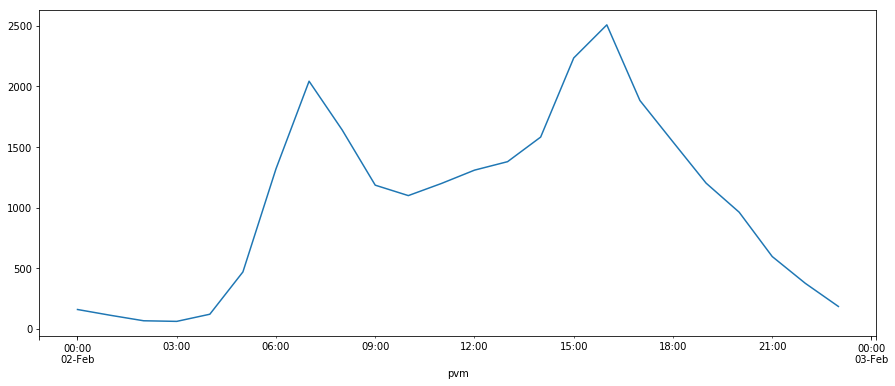

In [5]:
y.plot(figsize=(15, 6))
plt.show()

### Kerätään 365 päivän data

In [149]:
# Haetaan tieto pidemmältä ajalta
traffics = pd.DataFrame()
for pv in range(1,365):
    traffic = pd.read_csv("https://aineistot.liikennevirasto.fi/lam/rawdata/2017/09/lamraw_933_17_"+str(pv)+".csv", sep=";", names=cols)
    traffics = pd.concat([traffics, traffic])
    
# Lisätään 'pvm' sarake
traffics.insert(0, 'pvm', traffics.apply (lambda row: muunnos (row), axis=1))

# Päivämäärä indeksiksi
traffics = traffics.set_index('pvm')
traffics.sample(5)

,piste,vuosi,päivä nro,h,min,s,sadasosa s,pituus(m),kaista,suunta,ajoneuvon luokka,nopeus (km/h),faulty(0=ok),kokaika(tekn),aikav.(tekn),jonoalku(tekn)
pvm,,,,,,,,,,,,,,,,
2015-07-17 19:58:58,933,15,197,19,58,58,41,3.6,4,2,1,100,0,7193841,527,0
2015-10-13 20:00:47,933,15,285,20,0,47,19,3.8,4,2,1,79,0,7204719,488,0
2015-06-19 14:51:10,933,15,169,14,51,10,18,3.6,1,1,1,105,0,5347018,473,0
2015-07-10 12:27:01,933,15,190,12,27,1,67,3.6,1,1,1,93,0,4482167,778,0
2015-09-30 13:48:06,933,15,272,13,48,6,25,3.6,4,2,1,95,0,4968625,311,0


### Datan tallennus CSV:nä

In [150]:
# Tallennetaan kerätty data
savedata = traffics
savedata['pvm'] = traffics.index
savedata.to_csv("LAM-2017-vt4palokka-raw.csv")

### CSV-datan lukeminen

In [6]:
cols = ['piste', 'vuosi', 'päivä nro', 'h', 'min', 's', 'sadasosa s', 'pituus(m)',
        'kaista', 'suunta', 'ajoneuvon luokka', 'nopeus (km/h)', 'faulty(0=ok)', 
        'kokaika(tekn)', 'aikav.(tekn)', 'jonoalku(tekn)']

# Ladataan aiemmin kerätty data, pvm indeksinä
traffics = pd.read_csv("LAM-2017-vt4palokka-raw.csv", index_col='pvm')

# Asetetaan indeksin tyypiksi datetime
traffics.index = pd.to_datetime(traffics.index)

# Indeksi on DateTimeIndex
traffics.index

#...parse_dates=['pvm'], index_col='pvm',date_parser=dateparse
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

DatetimeIndex(['2017-01-02 00:00:18', '2017-01-02 00:00:21',
               '2017-01-02 00:00:59', '2017-01-02 00:01:03',
               '2017-01-02 00:01:26', '2017-01-02 00:01:39',
               '2017-01-02 00:01:46', '2017-01-02 00:01:55',
               '2017-01-02 00:02:16', '2017-01-02 00:02:27',
               ...
               '2017-12-31 23:57:40', '2017-12-31 23:57:57',
               '2017-12-31 23:58:40', '2017-12-31 23:58:46',
               '2017-12-31 23:58:54', '2017-12-31 23:59:07',
               '2017-12-31 23:59:10', '2017-12-31 23:59:11',
               '2017-12-31 23:59:44', '2017-12-31 23:59:47'],
              dtype='datetime64[ns]', name='pvm', length=9289954, freq=None)

In [7]:
# Koska indeksin tyyppi on 'DateTimeIndex', niin esim tietyn minuutin (4:30) tiedot saadaan:
traffics['2017-02-01 04:30']

,piste,vuosi,päivä nro,h,min,s,sadasosa s,pituus(m),kaista,suunta,ajoneuvon luokka,nopeus (km/h),faulty(0=ok),kokaika(tekn),aikav.(tekn),jonoalku(tekn),pvm.1
pvm,,,,,,,,,,,,,,,,,
2017-02-01 04:30:00,933,17,31,4,30,0,37,3.4,1,1,1,99,0,1620037,12544,0,2017-02-01 04:30:00
2017-02-01 04:30:22,933,17,31,4,30,22,62,4.0,1,1,1,110,0,1622262,2212,0,2017-02-01 04:30:22


### Aikasarjan tarkastelu, 1kk jakso

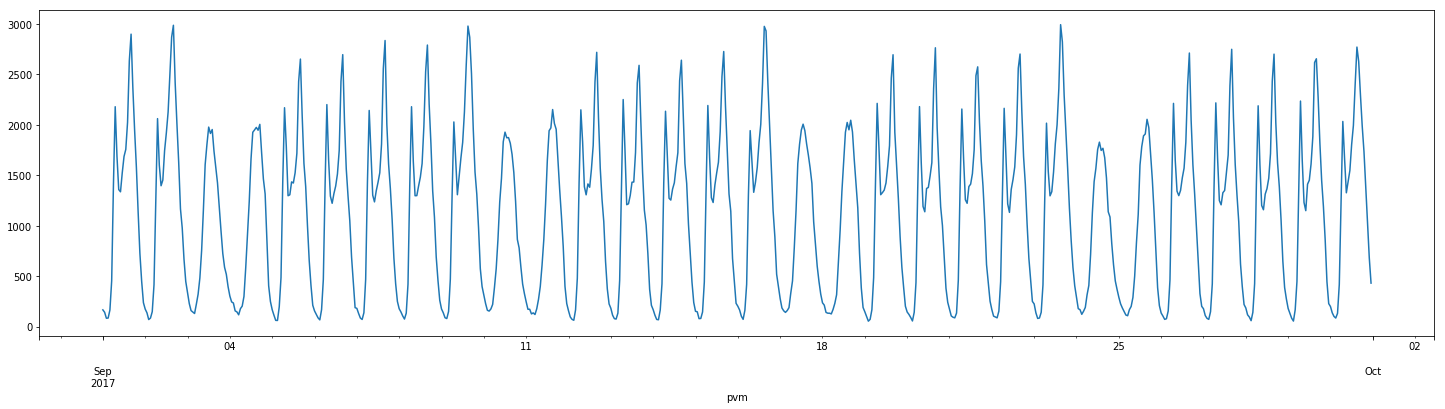

In [8]:
# Lasketaan tapahtumat haluttua aikaväliä kohti (24h)
days = traffics['suunta'].resample('60T').count()

# Resample-optiot (T, D, B ym.):
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation#17001474

# Liikennemäärät yhdeltä kuukaudelta
days['2017-09-01':'2017-09-30'].plot(figsize=(25, 6))
plt.show()

Kuukaudessa on nähtävissä kausivaihtelua (arkipäivät/viikonloppu)

### Aikasarjan tarkastelu, 1 vuosi

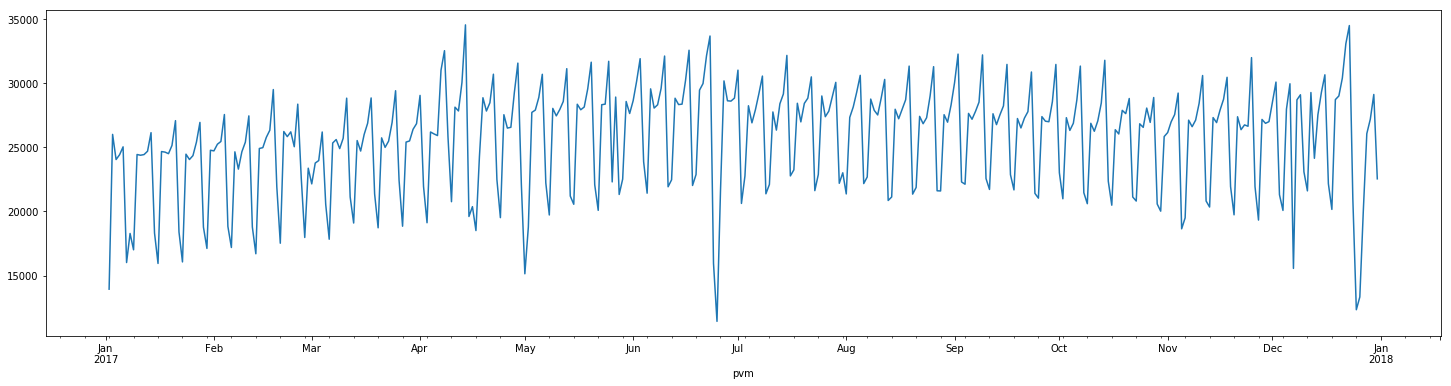

In [9]:
# Lasketaan tapahtumat haluttua aikaväliä kohti (24h)
days = traffics['suunta'].resample('1D').count()

# Resample-optiot (T, D, B ym.):
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation#17001474

# Liikennemäärät, vuosi 2017
days.plot(figsize=(25, 6))
plt.show()

---

### Kausivaihtelun hajonta liukuvalla keskiarvolla (seasonal decomposition using moving averages)

Mallit
>'Multiplicative' = trend _x_ seasonal _x_ random. 
Komponentit kerrotaan. Kasvavalla trendillä kausivaihtelun amplitudi lisääntyy. 

>'Additive' = seasonal + trend + random. 
Komponentit lasketaan yhteen. Kasvavalla trendillä amplitudi pysyy suurinpiirtein samana.

Ylläoleva aikasarja näyttää noudattavan enemmän *additiivista* aikasarjaa: kausivaihtelu pysyttelee enimmäkseen samoissa rajoissa. 

---
_Additive vai multiplicative? https://anomaly.io/seasonal-trend-decomposition-in-r/_

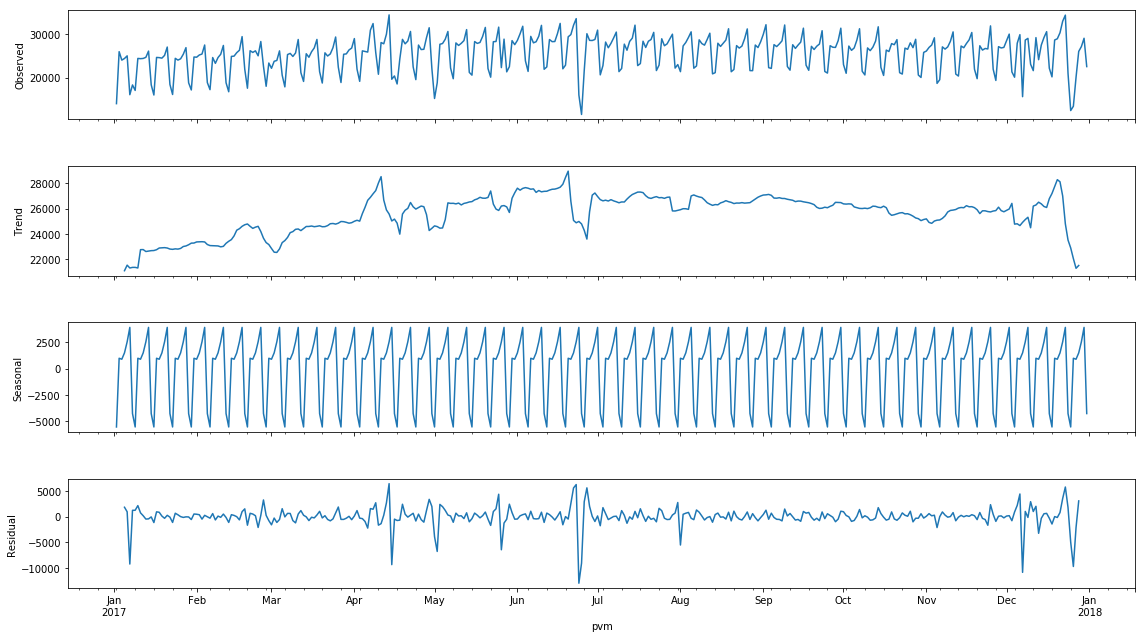

In [10]:
# Lasketaan tapahtumat aikaväliä kohti (1 päivä)
y = traffics['suunta'].resample('1D').count()

malli = 'Additive'

# * seasonal decomposition = kausihajonta
# * moving averige = liukuva keskiarvo
tulos = sm.tsa.seasonal_decompose(y, model=malli)

fig = tulos.plot()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

Käyrät
>Observed = mitatut arvot

>Trend = trendi, pitkäaikaismuutos

>Seasonal = kausivaihtelu, kuinka arvot muuttuvat esim vuosi/kk/viikko-kohtaisesti

>Residual = aikasarja, josta poistettu trendi ja kausivaihtelu

---


## Aikasarjaennuste, ARIMA -malli
*ARIMA - Auto-Regressive Integrated Moving Averages (ns. Box-Jenkins-mallit).*



ARIMA-mallin muodostaminen

### 1 . Stationarisoi data 

    - differensoimalla, käyttämällä havaintojen erotuksia 
    - logaritmimuunnoksella voidaan stationarisoida varianssia


### 2 . Tutki autokorrelaatiot ja osittaisautokorrelaatiot, onko malliin liitettävä :

    - AR-, autoregressiivinen prosessi, (p),
    - I, differenssit, (d),
    - MA- moving averige - liukuvakeskiarvoprosessi, (q)


### 3 . Sovita malli, tutki ACF ja PACF -käyrät
    
    - ACF(autocorrelation) autokorrelaatio
    - PACF(partial autocorrelation) osittaisautokorrelaatio 


### 4 . Kuviot, joita vielä näkyy ACF ja PACF -käyrissä, voi viitata tarpeeseen lisätä AR ja MA -prosesseja


---

    - Arima-malli koostuu koordinaateista(p,d,q), joiden arvot yleensä 0 tai 1, 
    isommat harvinaisempia.

    - p = tarkastelujen lukumäärä menneellä ajanjaksolla, esim jos 2, niin kahta 
    edellistä tarkastelua käytetään trendin ennustamiseen (autoregressiivi) (apuna PACF)

    - d = eroavaisuuksien määrä, jotka vaaditaan jotta aikasarjasta saadaan 
    muuttumaton (liukukeskiarvo)

    - q = mallin edellisten ennusteiden virheiden liukuva keskiarvo 
    (differenssiaste) (apuna ACF)



---


> _Lähteet_

> https://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf  

> https://yle.fi/aihe/sites/aihe/files/migrated/mot_ohjelmat/u321/Hjelt_Aikasarjamalleista.pdf

> http://jultika.oulu.fi/files/nbnfioulu-201411051965.pdf

> https://people.duke.edu/~rnau/arimrule.htm

> http://www.michaeljgrogan.com/arima-model-statsmodels-python/


---

### Datan stationaarisuus

Ennen kuin datan analyysissä voidaan edetä, datan on oltava stationaarista, eli mm. keskiarvo, varianssi ja autokorrelaatio pysyvät likimain vakiona, eikä trendiä ole nähtävissä. Yleensä taloudelliset aikasarjat ovat niissä näkyvän trendin vuoksi epästationaarisia.

Stationaarisuutta voidaan testata esim alla olevalla Laajennetulla Dickey-Fuller -testillä:


Statistiikka           -2.683787
P-arvo (MacKinnon)      0.076886
Viiveet(lag)           13.000000
Havainnot             350.000000
dtype: float64

Kriittiset arvot:  {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}


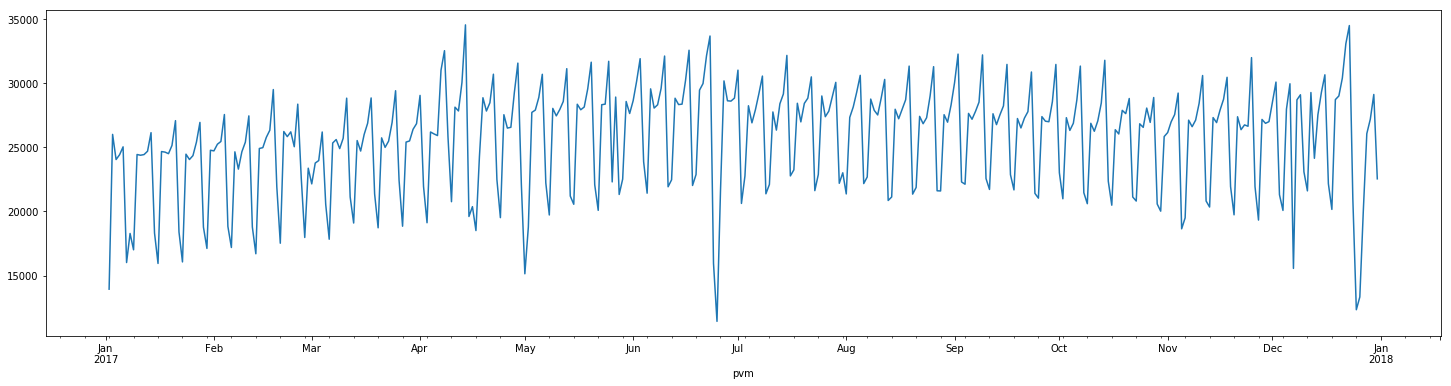

In [443]:
#Augmented Dickey Fuller (unit root test)
#https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test  

from statsmodels.tsa.stattools import adfuller, kpss

def adftesti(y):
    test = adfuller(y, autolag='AIC')

    print(pd.Series(test[0:4], index=["Statistiikka","P-arvo (MacKinnon)","Viiveet(lag)","Havainnot"]))
    print("\nKriittiset arvot: ",test[4])

adftesti(y)
y.plot(figsize=(25, 6))
plt.show()


Mitä negatiivisempi arvo statistiikassa, sitä todennäköisemmin aikasarja on stationaarinen. Statistiikan arvon pitäisi olla pienempi kuin kriittinen arvo, mutta -2.683787 on suurempi kuin 1% kriittinen arvo. Kuitenkin lähes sama kuin 5% kriittinen arvo.

P-arvo > 0.05 puolestaan kertoo, että aikasarja olisi non-stationaarinen.

> Koko vuoden aikasarjalla viikkoennuste ei onnistunut yrityksistä huolimatta, 
> parempi tulos saatiin lyhyemmällä, tasaisemmalla aikavälillä. 
> Aikasarjaa differensoimalla, se saadaan vielä paremmaksi:

Statistiikka         -6.081633e+00
P-arvo (MacKinnon)    1.088669e-07
Viiveet(lag)          1.200000e+01
Havainnot             7.800000e+01
dtype: float64

Kriittiset arvot:  {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}


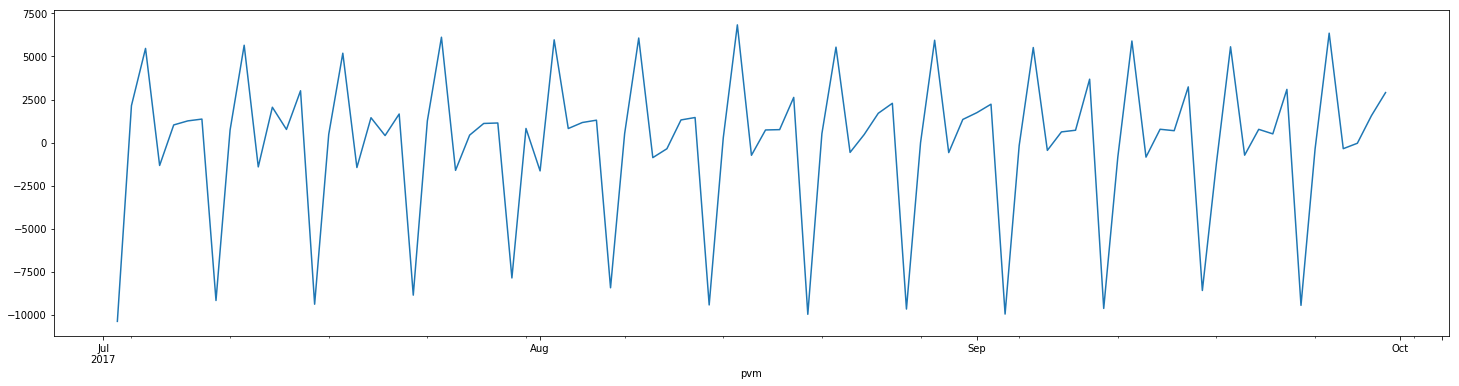

In [471]:
# Differensointi
#ydiff = ylog.diff(periods=1)
ydiff=y['2017-07':'2017-09'].diff(periods=1)
adftesti(ydiff[1:])
ydiff.plot(figsize=(25, 6))
plt.show()

Statistiikka          -2.801587
P-arvo (MacKinnon)     0.058047
Viiveet(lag)           7.000000
Havainnot             84.000000
dtype: float64

Kriittiset arvot:  {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}


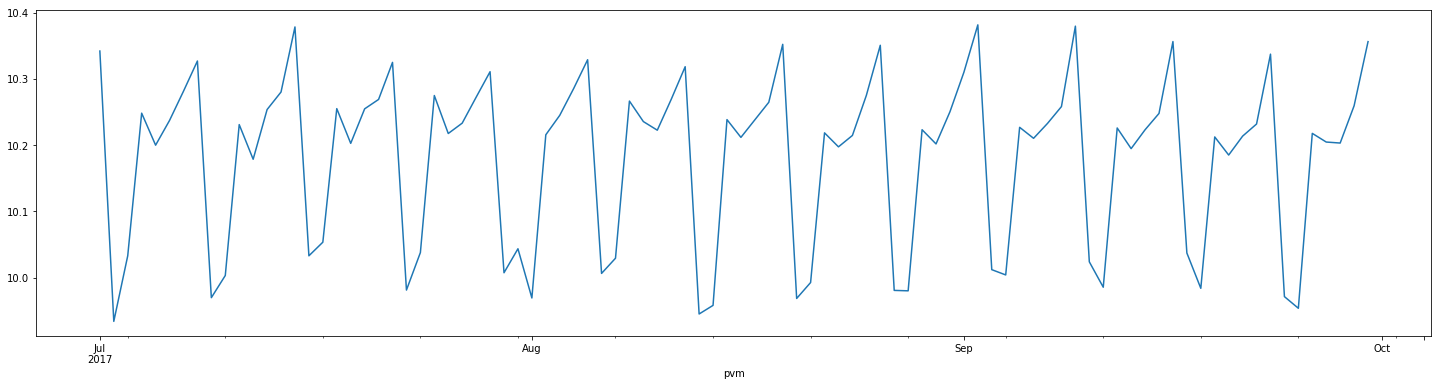

In [472]:
# Logaritmilla data saadaan lähemmäs hyväksyttäviä arvoja, jatkossa käytämme kuitenkin
# vain differensoitua aikasarjaa
ylog = np.log(y['2017-07':'2017-09'])
adftesti(ylog)
ylog.plot(figsize=(25, 6))
plt.show()

In [446]:
#http://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html

#plt.plot(y.index, y.diff(periods=1), label='Rolling Mean')
#plt.show()

### ACF ja PACF

Ennalta ei tiedetä prosessin tyyppiä, mutta aikasarjan havaittujen autokorrelaatioiden kautta saadaan mallia tunnistamiseen...

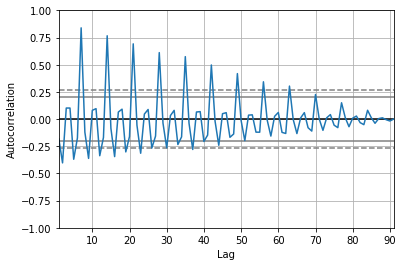

In [473]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from pandas.plotting import autocorrelation_plot

# https://www.youtube.com/watch?v=bqvZL8Ww3aA // how to identify p d q

autocorrelation_plot(ydiff[1:]) # 1kk ajalta
plt.show()

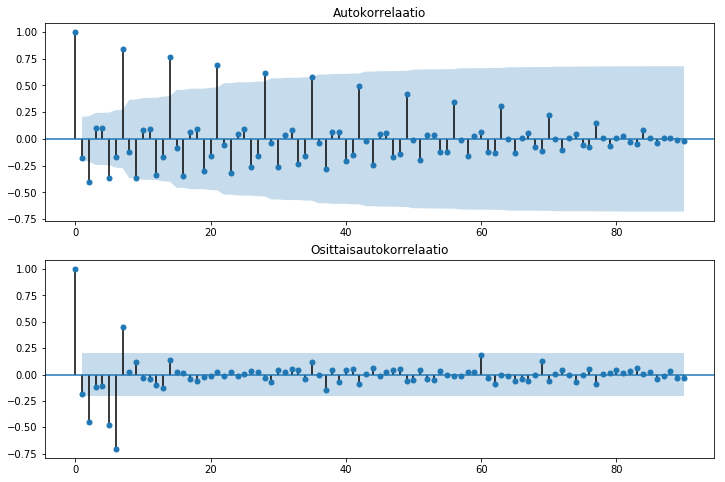

In [474]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ydiff[1:], ax=ax1,  title="Autokorrelaatio")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ydiff[1:], ax=ax2, title="Osittaisautokorrelaatio")
plt.show()


- AUTOKORRELAATIO: *q-arvo*, on kohta jossa lagit jää merkittävyysrajan alle

- PACF: *p-arvo* katsotaan kohdasta, jossa arvot tulee merkittävyysrajan sisäpuolelle

### Oikeiden arvojen etsiminen ARIMA-malliin

arma_order_select_ic:lla voidaan etsiä parhaita p, d, q -arvoja mallin tekemiseen, mutta se ei toimi hyvin aikasarjoihin, joissa on kausivaihtelua (seasonal)

In [372]:
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = sm.tsa.arma_order_select_ic(ydiff[1:], ic=['aic'], max_ar=8, max_ma=8, trend='nc')

print("(aic) AR, MA: ",res.aic_min_order)

(aic) AR, MA:  (6, 8)


### SARIMA (Seasonal ARIMA)

SARIMA-malleja on käytettävä, jos datassa on kausivaihteluita. Pythoniin asennettavalla pyramid-arima-kirjastolla voidaan tutkia, mitkä ovat parhaat p, d, q -arvot.

In [475]:
# pip install pyramid-arima
# https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html

from pyramid.arima import auto_arima

arima = auto_arima(ydiff[1:], start_p=1, start_q=1,
                           max_p=13, max_q=13, max_d=10, m=7,
                           max_P=2, max_Q=2, max_D=2,
                           start_P=0, seasonal=True, stationary=True,
                           trace=True, max_order=35, maxiter=100,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print("Paras aic: ",arima.aic())
print("Paras bic: ",arima.bic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=1684.319, BIC=1696.874, Fit time=0.717 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=1620.360, BIC=1630.403, Fit time=0.667 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=1684.556, BIC=1694.599, Fit time=0.445 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=1785.274, BIC=1792.807, Fit time=0.032 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=1598.414, BIC=1610.968, Fit time=1.441 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=1583.082, BIC=1598.147, Fit time=2.610 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=1570.299, BIC=1587.875, Fit time=1.987 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 0, 1, 7); AIC=1

### Mallin sovittaminen

Auto-ariman mukaan paras tulos saadaan parametreillä:

order=(3, 0, 0) seasonal_order=(1, 0, 1, 7)

In [477]:
# order = ARIMA(p,d,q) (non-seasonal)
# seasonal_order = seasonal ARIMA (P,D,Q)s (seasonal). 
# S = aikasarjan säännöllisyys, esim 12 on vuosi, 7 viikkotaso
mod = sm.tsa.statespace.SARIMAX(endog=ydiff[1:],
                                order=(3,0,0),
                                seasonal_order=(1,0,1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    results = mod.fit()
    print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6066      0.057    -10.686      0.000      -0.718      -0.495
ar.L2         -0.3978      0.094     -4.220      0.000      -0.582      -0.213
ar.L3         -0.1691      0.105     -1.608      0.108      -0.375       0.037
ar.S.L7        1.0023      0.017     58.719      0.000       0.969       1.036
ma.S.L7       -0.7639      0.114     -6.706      0.000      -0.987      -0.541
sigma2      1.215e+06   1.25e+05      9.709      0.000     9.7e+05    1.46e+06


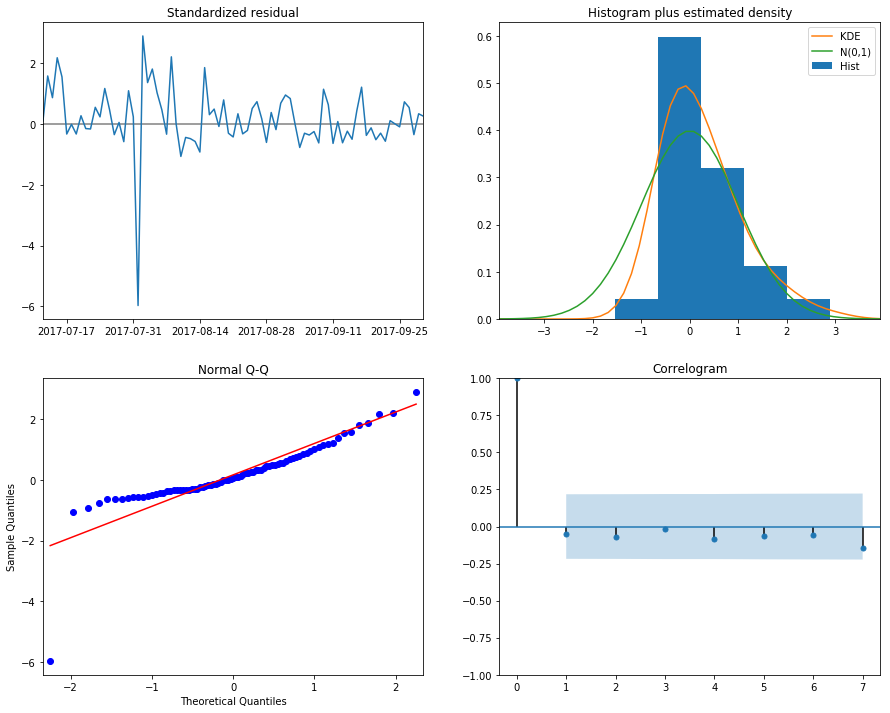

In [478]:
results.plot_diagnostics(figsize=(15, 12), lags=7)
plt.show()

Standardized residual: ei pitäisi näkyä selkeää kausivaihtelua, vain "valkoista kohinaa".

Histogram plus estimated density: KDE käyrä pitäisi olla mahd. lähellä N -käyrää.

Normal Q-Q: Arvojen pitäisi seurata viivaa mahd. hyvin. 

Correlogram: Autokorrelaatio, jäännösarvoilla pitäisi olla mahd. pieni korrelaatio aiempiin arvoihin nähden.

---

### Ennusteen tarkastelu

Aikasarjan visualisointi ja siitä tehty rinnakkaisennuste mallin arvioimiseksi

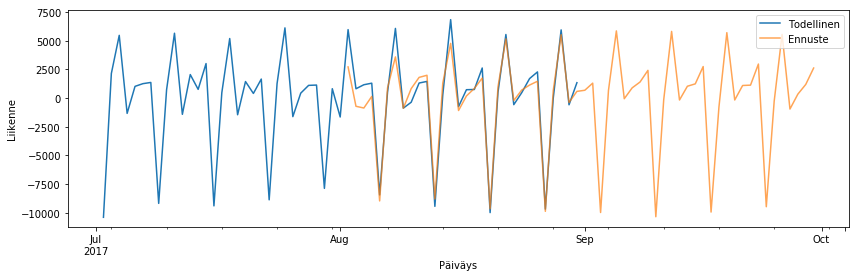

In [479]:
pred = results.get_prediction(start='2017-08-02',end='2017-09-30', dynamic=False)

#predci = pred.conf_int() # "confidence interval"

ax = ydiff['2017-07':'2017-08'].plot(label='Todellinen', figsize=(14,4))

pred.predicted_mean.plot(ax=ax, label='Ennuste', alpha=.7)

#ax.fill_between(predci.index, predci.iloc[:, 0], predci.iloc[:, 1], color='b', alpha=.1)

ax.set_xlabel('Päiväys')
ax.set_ylabel('Liikenne')
plt.legend()
plt.show()

### Seuraavien viikkojen ennuste

Alkuperäinen aikasarja + kuukauden ennuste siitä eteenpäin

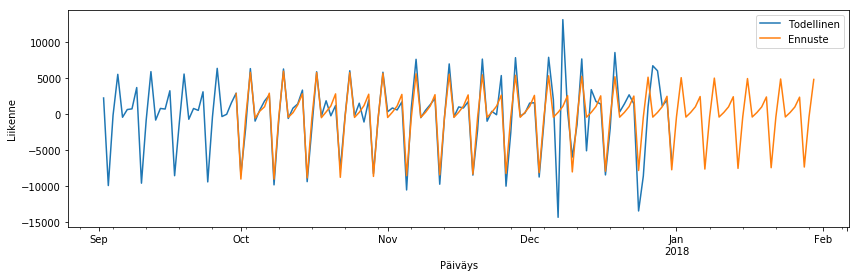

In [469]:
ax = y['2017-09':'2017-12'].diff(periods=1).plot(label='Todellinen', figsize=(14,4))

pred = results.predict(start="2017-09-30", end="2018-01-30", dynamic="2017-09-30")
pred.plot(label='Ennuste')

ax.set_xlabel('Päiväys')
ax.set_ylabel('Liikenne')
plt.legend()
plt.show()

### Eri tapa visualisoida ACF / PACF

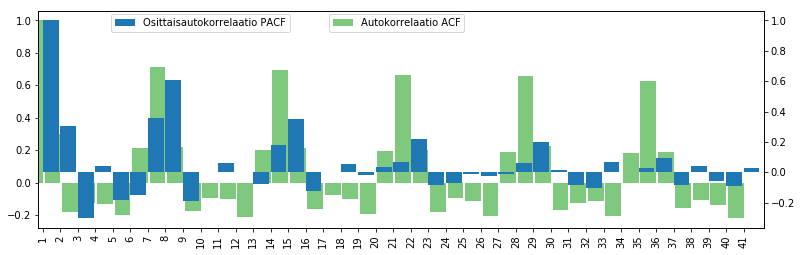

In [288]:
# ACF
ACF = (acf(y)).T
test = pd.DataFrame(ACF, columns=['Autokorrelaatio ACF'])
test.index += 1 # aloitetaan indeksi ykkösestä

# PACF
PACF = (pacf(y)).T
test2 = pd.DataFrame(PACF, columns=['Osittaisautokorrelaatio PACF'])
test2.index += 1 # aloitetaan indeksi ykkösestä


fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.9
test.plot(kind='bar', ax=ax, width=width, position=1, figsize=(13,4), colormap='Accent', legend=False)
test2.plot(kind='bar', ax=ax2, width=width, position=0, legend=False)

# Legendit eri kohtiin
patches, labels = ax.get_legend_handles_labels()
patches2, labels2 = ax2.get_legend_handles_labels()
ax.legend(patches, labels, loc=(0.4,0.9))
ax2.legend(patches2, labels2, loc=(0.1,0.9))

plt.show()